In [1]:
import numpy as np

from GmGM import GmGM
from GmGM.synthetic import PrecMatGenerator, DatasetGenerator
from GmGM.synthetic import PrecMatErdosRenyiGilbert
from GmGM.synthetic import measure_prec_recall, plot_prec_recall

In [2]:
generator = DatasetGenerator(
    structure={
        "rna": ("cell", "gene"),
        "atac": ("cell", "peak"),
    },
    generator={
        "cell": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.2),
        ),
        "gene": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.2),
        ),
        "peak": PrecMatGenerator(
            mask=PrecMatErdosRenyiGilbert(edge_probability=0.2),
        ),
    },
    size={
        "cell": 51,
        "gene": 52,
        "peak": 53
    },
)
generator

In [3]:
generator.generate()

Dataset(
	rna: ('', 'cell', 'gene')
	atac: ('', 'cell', 'peak')
)
Axes(
	peak: 53
		Prior: None
		Gram: Not calculated
		Eig: Not calculated
	gene: 52
		Prior: None
		Gram: Not calculated
		Eig: Not calculated
	cell: 51
		Prior: None
		Gram: Not calculated
		Eig: Not calculated
)

Attempt 1/5
Attempt 2/5
Attempt 3/5
Attempt 4/5
Attempt 5/5


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Recall', ylabel='Precision'>)

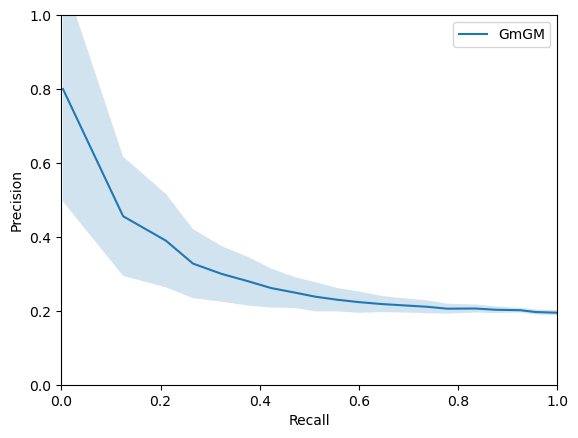

In [4]:
results = measure_prec_recall(
    generator,
    algorithms={
        "GmGM": lambda dataset, lambdas: GmGM(dataset, lambdas, threshold_method="overall"),
    },
    Lambdas={
        "GmGM": np.linspace(0.001, 1, 20)
    },
    num_attempts=5,
    num_samples=10,
    verbose=1,
)
plot_prec_recall(
    results,
    axis = "cell",
    generator=generator,
)